(stan-binomial-regression-notebook)=
# Regressione binomiale con Stan

Il presente capitolo approfondisce il concetto di regressione binomiale, una metodologia analitica specifica utilizzata per esaminare le variabili dipendenti che rappresentano le proporzioni di successi derivanti da un numero $n$ di tentativi. A differenza della regressione logistica, dove la variabile dipendente segue una distribuzione di Bernoulli con esiti binari, la regressione binomiale si concentra sulle variabili dipendenti che esprimono proporzioni. Questo rende il modello binomiale la scelta più appropriata per analizzare dati di questo tipo. Sia nella regressione logistica che in quella binomiale, è cruciale rispettare il principio di indipendenza delle osservazioni. Questo requisito è essenziale per garantire la validità e l'affidabilità delle analisi condotte.

## Preparazione del Notebook

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
from scipy.special import expit  # Funzione logistica

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_binomial_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

## Regressione Binomiale

Nella regressione binomiale, l'attenzione è focalizzata sui dati che si esprimono attraverso eventi dicotomici, ossia successi o insuccessi, in un determinato numero di prove. Un esempio classico è il conteggio dei successi in una serie di tentativi, come "3 successi su 7 tentativi". Il modello matematico che descrive questo tipo di dati è:

$$
y_i \sim \text{Binomiale}(n_i, p_i)
$$

dove:
- $y_i$ rappresenta il numero di successi osservati;
- $n_i$ è il numero totale di tentativi per l'i-esima osservazione;
- $p_i$ indica la probabilità di successo in ogni tentativo per l'i-esima osservazione.

Nel contesto della regressione binomiale, l'obiettivo principale è modellare e stimare la probabilità di successo $p_i$ in funzione di una o più variabili indipendenti (i predittori). Questo si realizza attraverso l'utilizzo di una funzione di collegamento che trasforma una combinazione lineare dei predittori in un valore che risiede nello spazio di probabilità $[0,1]$, rendendolo interpretabile come probabilità di successo.

La funzione logistica inversa, o logit inverso, è la funzione di collegamento più comunemente usata nella regressione binomiale. Questa trasforma la somma lineare dei predittori in una probabilità, usando la formula:

$$
p_i = \text{InverseLogit}(\beta_0 + \beta_1 \cdot x_{i1} + \dots + \beta_k \cdot x_{ik})
$$

dove:
- $p_i$ è la probabilità stimata di successo per l'i-esima osservazione;
- $x_{i1}, \dots, x_{ik}$ sono le variabili indipendenti;
- $\beta_0, \beta_1, \dots, \beta_k$ sono i parametri del modello da stimare, inclusa l'intercetta ($\beta_0$) e i coefficienti per ciascun predittore ($\beta_1, \dots, \beta_k$).

La funzione $\text{InverseLogit}(\eta) = \frac{1}{1 + e^{-\eta}}$ assicura che il risultato sia sempre tra 0 e 1, permettendo di interpretarlo come probabilità. Questo è cruciale perché ci consente di mantenere la coerenza interpretativa dei risultati nel contesto della probabilità di eventi dicotomici.

In conclusione, la regressione binomiale offre un framework robusto per analizzare e interpretare le relazioni tra variabili indipendenti e la probabilità di eventi binari, sfruttando la distribuzione binomiale e trasformazioni logistiche per collegare predittori lineari a probabilità comprese tra 0 e 1.

Adottando un approccio bayesiano alla regressione binomiale, è possibile incorporare le informazioni precedenti o le conoscenze priori sui parametri $\beta$, attraverso l'uso di distribuzioni a priori. Questo approccio permette di aggiornare le nostre credenze sui parametri del modello alla luce dei dati osservati, producendo una distribuzione a posteriori che riflette sia le informazioni apportate dai dati che le conoscenze pregresse.

## Un esempio concreto

Seguiamo il tutorial fornito sul sito ufficiale di PyMC e generiamo dei dati sintetici.

In [3]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
display(data)

,x,y
0,-10.000000,1
1,-8.965517,0
2,-7.931034,1
3,-6.896552,2
4,-5.862069,6
5,-4.827586,7
6,-3.793103,4
7,-2.758621,14
8,-1.724138,14
9,-0.689655,9


Creiamo un dizionario nel formato richiesto per l'input a CmdStan:

In [4]:
stan_data = {
    "sample_size": data.shape[0],
    "x": data["x"],
    "y": data["y"],
    "n": 20
}

Importiamo il file con il codice Stan:

In [5]:
stan_file = os.path.join('stan', 'binomial_regression.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> sample_size;  // Numero totale di osservazioni
  vector[sample_size] x;     // Variabile indipendente
  array[sample_size] int<lower=0> y;  // Successi per ogni tentativo
  int<lower=0> n;           // Numero di tentativi per osservazione
}
parameters {
  real beta0;  // Intercetta
  real beta1;  // Pendenza
}
transformed parameters {
  vector[sample_size] eta = beta0 + beta1 * x;  // Modello lineare
  vector[sample_size] p = inv_logit(eta);       // Probabilità di successo
}
model {
  // Priori
  beta0 ~ normal(0, 1);
  beta1 ~ normal(0, 1);

  // Likelihood
  y ~ binomial(n, p);
}



Compiliamo il modello:

In [6]:
model = CmdStanModel(stan_file=stan_file)

Eseguiamo il campionamento.

In [7]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

07:53:11 - cmdstanpy - INFO - CmdStan start processing
07:53:11 - cmdstanpy - INFO - Chain [1] start processing
07:53:11 - cmdstanpy - INFO - Chain [2] start processing
07:53:11 - cmdstanpy - INFO - Chain [3] start processing
07:53:11 - cmdstanpy - INFO - Chain [4] start processing
07:53:11 - cmdstanpy - INFO - Chain [2] done processing
07:53:11 - cmdstanpy - INFO - Chain [3] done processing
07:53:11 - cmdstanpy - INFO - Chain [1] done processing
07:53:11 - cmdstanpy - INFO - Chain [4] done processing


Per visualizzare e descrivere la distribuzione a posteriori dei parametri è possibile utilizzare ArviZ dopo aver fittato il modello con cmdstanpy. ArviZ utilizza un formato di dati chiamato `InferenceData`, che è un formato ad alto livello per la memorizzazione di risultati statistici. cmdstanpy restituisce un oggetto `CmdStanMCMC`, che può essere convertito in `InferenceData` utilizzando la funzione `az.from_cmdstanpy`.

In [8]:
idata = az.from_cmdstanpy(fit)

Otteniamo un riassunto delle statistiche posteriori:

In [9]:
summary = az.summary(fit, var_names=(["beta0", "beta1"]), hdi_prob=0.94)
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  0.761  0.149   0.493    1.055      0.002    0.002    4811.0    4852.0   
beta1  0.381  0.033   0.321    0.445      0.000    0.000    4536.0    4757.0   

       r_hat  
beta0    1.0  
beta1    1.0  


Mostriamo le distribuzioni a posteriori e le tracce di campionamento per i parametri:

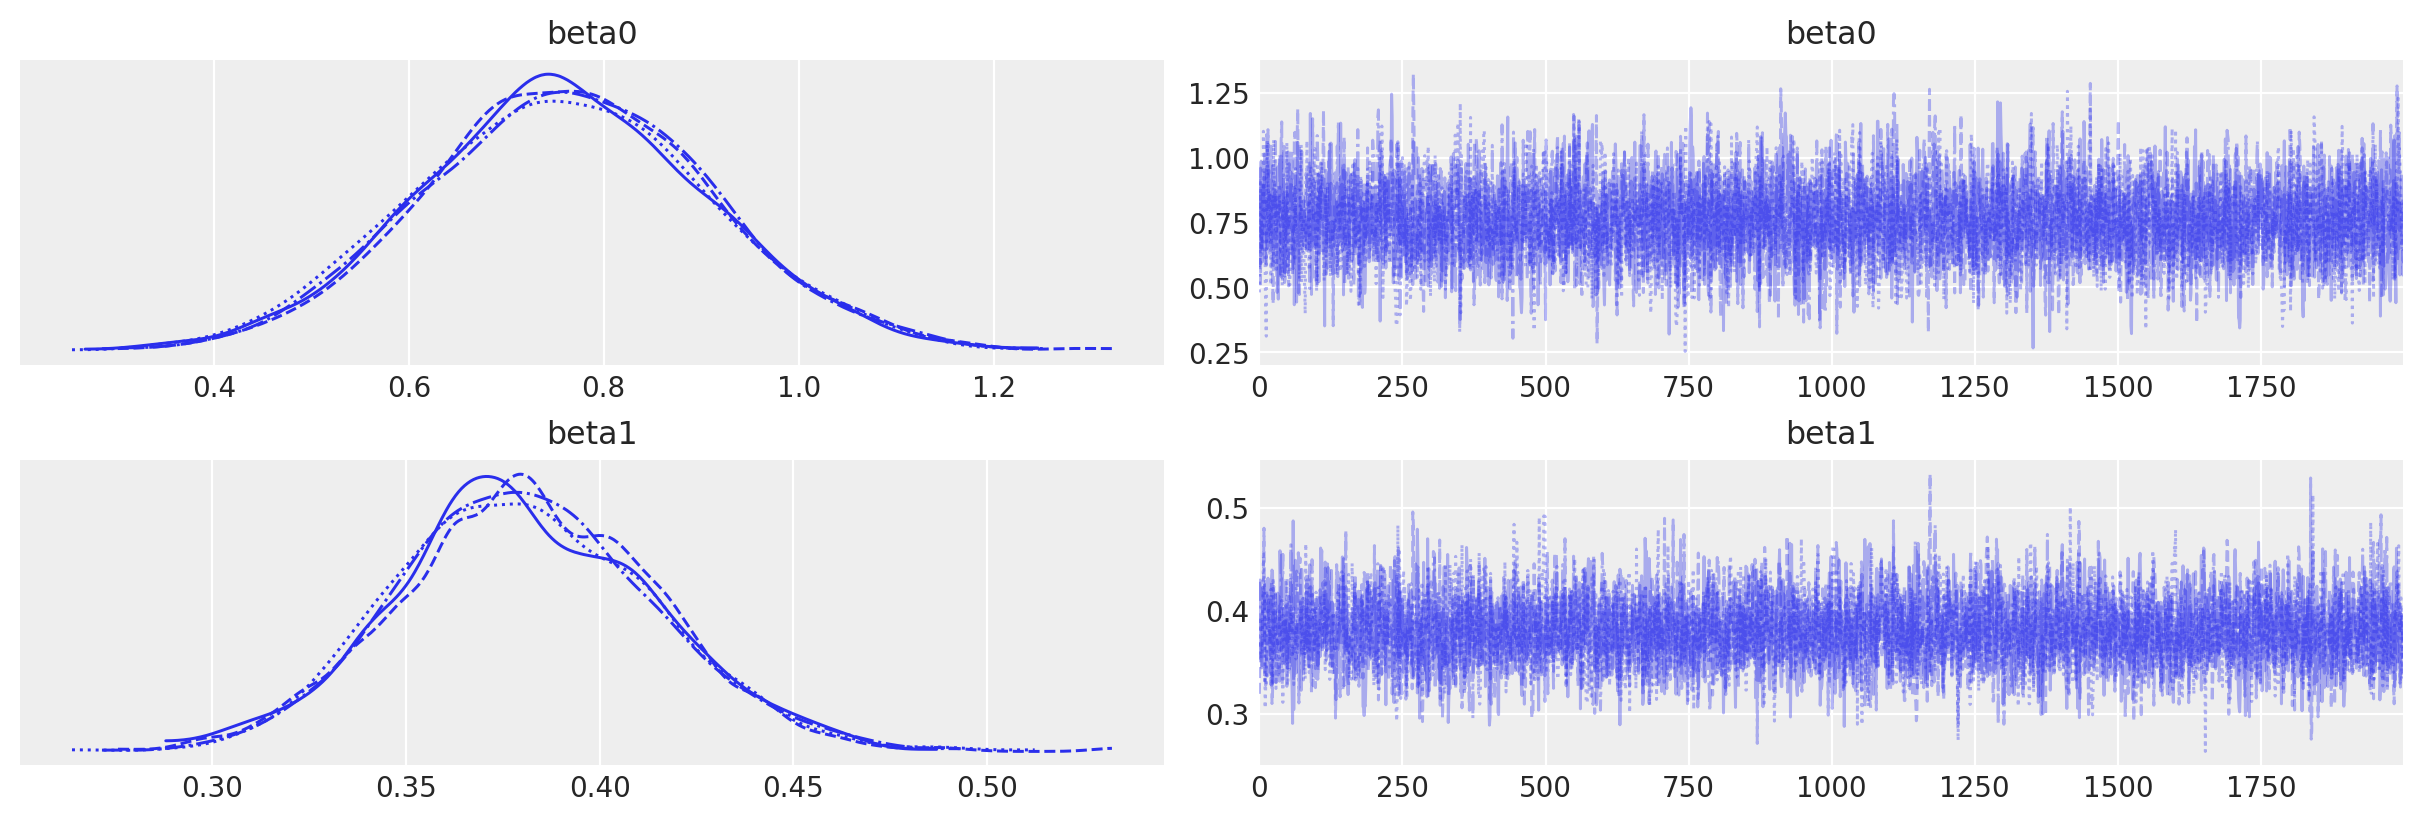

In [10]:
_ = az.plot_trace(fit, var_names=(["beta0", "beta1"]))

Nel pannello superiore della figura seguente vediamo il modello lineare nella sua forma non trasformata. Come si può osservare, questo modello lineare genera valori che escono dall'intervallo [0, 1], sottolineando quindi la necessità di una funzione di collegamento inversa. Questa funzione ha il compito di mappare i valori dal dominio dei numeri reali all'intervallo [0, 1]. Come abbiamo visto, questa trasformazione è realizzata mediante la funzione logistica inversa.

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_81593/1160461270.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


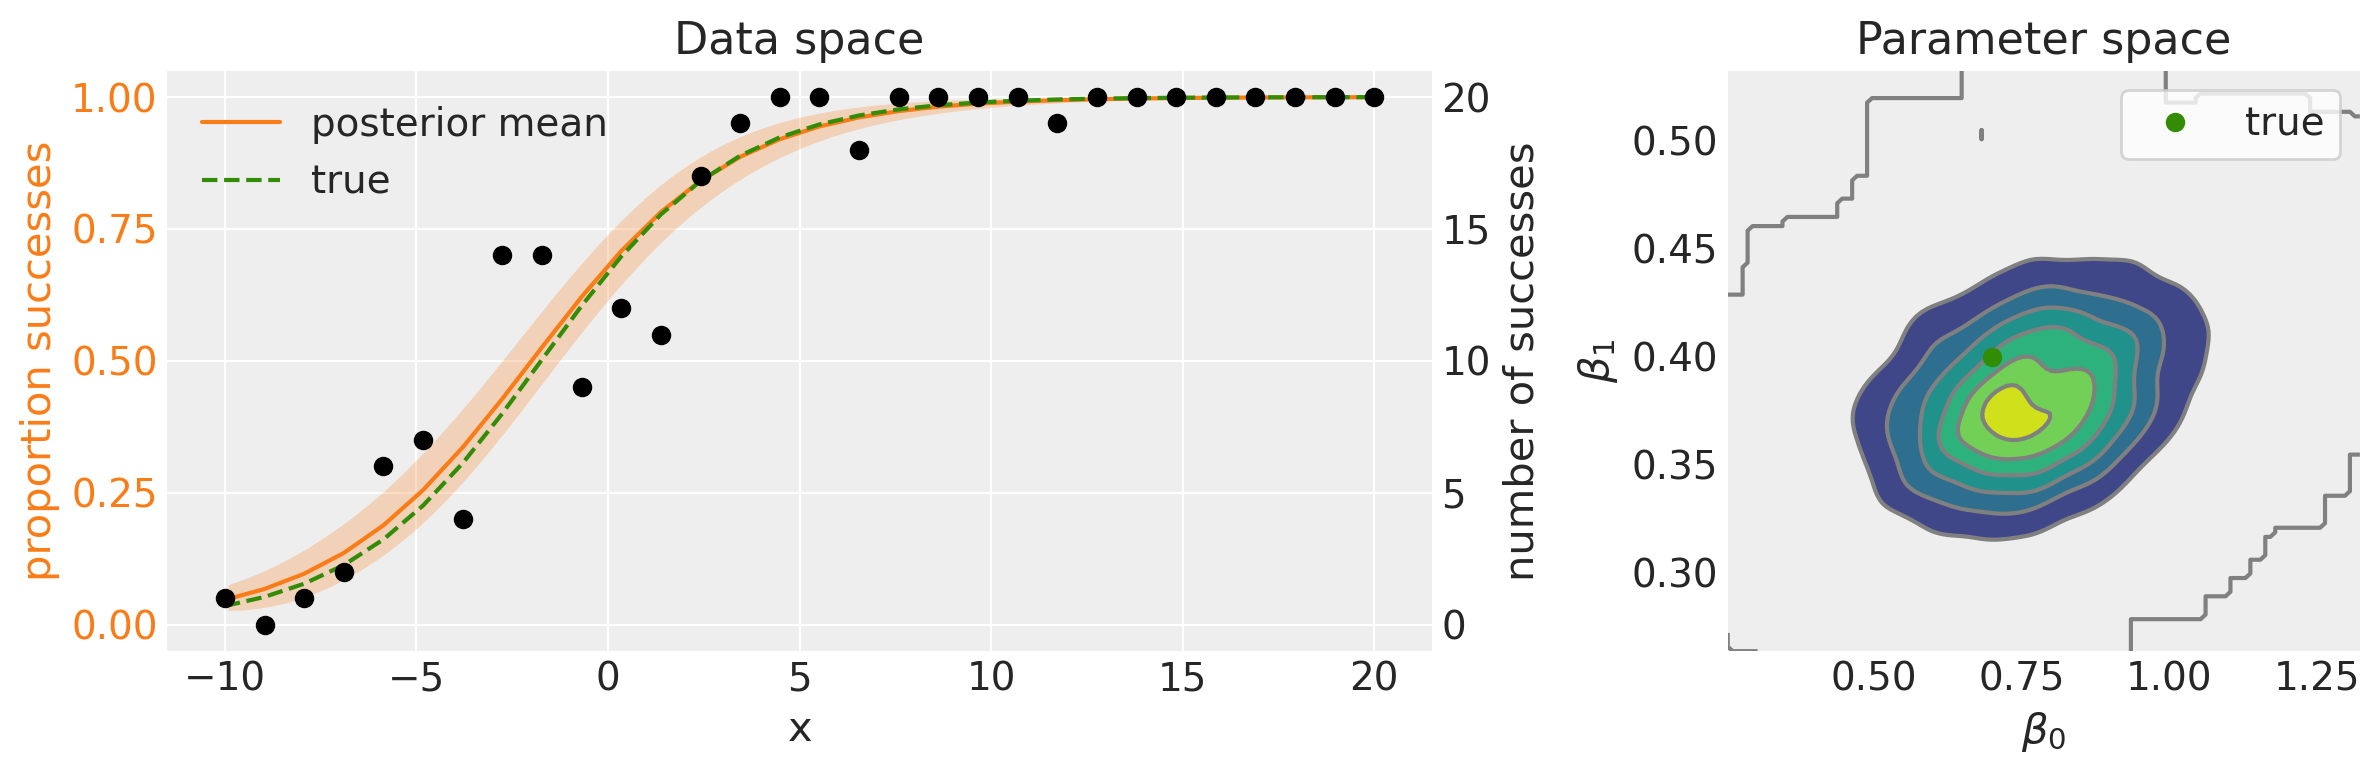

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True)
plt.tight_layout()

## Informazioni sull'Ambiente di Sviluppo

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Wed Jul 17 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.9.1
arviz     : 0.18.0

Watermark: 2.4.3

